### eFiche Data Engineering Challenge: PadChest Dataset Exploration

### eFiche Data Engineering Take-Home Assessment
  - Names: Eric Maniraguha
  - Email: ericmaniraguha@gamil.com


In [ ]:
# 1. Installed required libraries

!pip install dataset --quiet
!pip install pandas sqlalchemy psycopg2 faker datasets --quiet
!pip install -U datasets huggingface_hub fsspec --quiet
!pip install datasets huggingface_hub --quiet


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# 2. Set up Hugging Face authentication

from google.colab import userdata
userdata.get('----')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# 3. Explored PadChest / IMT-CXR dataset

import pandas as pd

df = pd.read_csv("hf://datasets/MedHK23/IMT-CXR/MIMIC_classification-location_train.tsv", sep="\t")
df

,0,0.1,0.2,"atelectasis, right&base"
0,1,1,1,"effusion, right&base"
1,2,2,2,"fracture, left&base"
2,3,3,3,"effusion, right&mid"
3,4,4,4,"pneumonia, left"
4,5,5,5,"pneumonia, right"
5,6,6,6,"consolidation, right"
6,7,7,7,"atelectasis, left"
7,8,8,8,"effusion, left"
8,9,9,9,"atelectasis, right&base"


### Set up Hugging Face Token in Colab Secrets

1.  **Generate a Hugging Face Token**: If you don't have one, go to your Hugging Face profile settings (https://huggingface.co/settings/tokens) and create a new access token. Make sure it has the "write" role if you plan to push models/datasets.
2.  **Add to Colab Secrets**: In your Colab notebook, click on the "🔑 Secrets" icon in the left sidebar.
3.  **Create New Secret**: Click on "+ New secret".
4.  **Name the Secret**: Enter ` ----` as the "Name" for the secret.
5.  **Paste Your Token**: Paste your generated Hugging Face token into the "Value" field.
6.  **Enable Notebook Access**: Make sure to toggle on "Notebook access" for the `HF_TOKEN` secret in your current notebook.

After these steps, the `userdata.get('HF_TOKEN')` call in your notebook should successfully retrieve the token.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   0                        9 non-null      int64 
 1   0.1                      9 non-null      int64 
 2   0.2                      9 non-null      int64 
 3   atelectasis, right&base  9 non-null      object
dtypes: int64(3), object(1)
memory usage: 420.0+ bytes


In [ ]:
# 4. Defined a function to fetch batches from HF

from huggingface_hub import hf_hub_download
import pandas as pd
import os

def get_training_batch_from_hf():
    """
    Load training batch from Hugging Face IMT-CXR dataset.
    Downloads files using hf_hub_download and reads with pandas.
    Returns original dataset without randomization or synthetic data.
    """

    batch_size = 256
    cla_num = int(batch_size * 0.15)  # ~38 classification examples
    loc_num = int(batch_size * 0.2)   # ~51 localization examples
    report_num = int(batch_size * 0.5) # ~128 report generation examples
    seg_num = batch_size - (cla_num + loc_num + report_num)  # ~39 segmentation examples

    batch_info = []

    # Define files to download
    files_config = [
        {
            'name': 'MIMIC_classification_report-generation_train.tsv',
            'limit': report_num,
            'task': 'report_generation'
        },
        {
            'name': 'Padchest_classification.tsv',
            'limit': cla_num,
            'task': 'classification'
        }
        ,
        {
            'name': 'VinDR_CXR_localization.tsv',
            'limit': loc_num,
            'task': 'localization'
        },
        {
            'name': 'CheXmask_lung_segmentation.tsv',
            'limit': seg_num,
            'task': 'segmentation'
        }
    ]

    # Download and process each file
    for file_config in files_config:
        filename = file_config['name']
        task_type = file_config['task']
        limit = file_config['limit']

        try:
            print(f"Downloading {task_type} dataset: {filename}...")

            # Download the file
            file_path = hf_hub_download(
                repo_id="MedHK23/IMT-CXR",
                filename=filename,
                repo_type="dataset"
            )

            print(f"  ✓ Downloaded to: {file_path}")

            # Read the TSV file
            df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip')

            print(f"  ✓ Loaded TSV with {len(df)} rows")
            print(f"  Columns: {list(df.columns)}")

            # Extract data from the first 'limit' rows
            count = 0
            for idx, row in df.iterrows():
                if count >= limit:
                    break

                # Check for Instruction and Answer columns
                instruction = None
                answer = None

                if 'Instruction' in df.columns and 'Answer' in df.columns:
                    instruction = row.get('Instruction', '')
                    answer = row.get('Answer', '')
                else:
                    # Try to infer from available columns
                    cols = df.columns.tolist()
                    if len(cols) >= 2:
                        # Use first two non-ID columns
                        for col in cols:
                            if col.lower() not in ['id', 'unnamed: 0']:
                                instruction = str(row[cols[0]])
                                answer = str(row[cols[1]])
                                break

                if instruction and answer and instruction.strip() and answer.strip():
                    batch_info.append([
                        instruction,
                        answer,
                        row.get('ID', f'{task_type}_{count}') if 'ID' in df.columns else f'{task_type}_{count}',
                        task_type
                    ])
                    count += 1

            print(f"  ✓ Extracted {count} {task_type} examples\n")

        except Exception as e:
            print(f"  ✗ Error processing {filename}: {e}\n")

    # Create DataFrame with original order (no shuffling)
    if batch_info:
        batch_df = pd.DataFrame(
            batch_info,
            columns=['Instruction', 'Answer', 'ID', 'Task']
        )
    else:
        batch_df = pd.DataFrame(columns=['Instruction', 'Answer', 'ID', 'Task'])

    return batch_df


if __name__ == '__main__':
    print("Starting dataset download and processing...\n")
    batch_df = get_training_batch_from_hf()

    print("=" * 60)
    print(f"✓ Generated batch with {len(batch_df)} examples\n")

    if len(batch_df) > 0:
        print("Task distribution:")
        print(batch_df['Task'].value_counts())
        print(f"\nFirst 5 examples:")
        print(batch_df.head())
        print(f"\nDataFrame info:")
        print(batch_df.info())
    else:
        print("No data was extracted. Please check the dataset structure.")

Starting dataset download and processing...



MIMIC_classification_report-generation_t(…):   0%|          | 0.00/4.77k [00:00<?, ?B/s]

  ✓ Downloaded to: /root/.cache/huggingface/hub/datasets--MedHK23--IMT-CXR/snapshots/a6a26a6d66a4972de315c142888742b404387ab8/MIMIC_classification_report-generation_train.tsv
  ✓ Loaded TSV with 9 rows
  Columns: ['0', '0.1', '0.2', 'the tubular opacities extending upward from the left hilus have been present with very little change since . i think this is probably a complex of dilated partially impacted bronchi . there may be other tiny impacted bronchi just inferior to it, but evaluation of all of these structures is more reliable on ct scanning . heart is top-normal size . leftward deviation of the trachea at the thoracic inlet could be due either to a large and tortuous innominate artery or right thyroid nodule  .', 'Lung Lesion&&Lung Opacity&&Nodule']
  ✓ Extracted 9 report_generation examples



Padchest_classification.tsv:   0%|          | 0.00/784 [00:00<?, ?B/s]

  ✓ Downloaded to: /root/.cache/huggingface/hub/datasets--MedHK23--IMT-CXR/snapshots/a6a26a6d66a4972de315c142888742b404387ab8/Padchest_classification.tsv
  ✓ Loaded TSV with 9 rows
  Columns: ['0', '0.1', 'Emphysema', '6/214128984872345146666867668007032315222_7o4mt5.png']
  ✓ Extracted 9 classification examples



VinDR_CXR_localization.tsv:   0%|          | 0.00/714 [00:00<?, ?B/s]

  ✓ Downloaded to: /root/.cache/huggingface/hub/datasets--MedHK23--IMT-CXR/snapshots/a6a26a6d66a4972de315c142888742b404387ab8/VinDR_CXR_localization.tsv
  ✓ Loaded TSV with 9 rows
  Columns: ['0', '0.1', 'Nodule', '515,1168,692,1330', '0d03df2e9ed557d0c9edcec777056c1f.jpg']
  ✓ Extracted 9 localization examples



CheXmask_lung_segmentation.tsv: 0.00B [00:00, ?B/s]

  ✓ Downloaded to: /root/.cache/huggingface/hub/datasets--MedHK23--IMT-CXR/snapshots/a6a26a6d66a4972de315c142888742b404387ab8/CheXmask_lung_segmentation.tsv
  ✓ Loaded TSV with 9 rows
  Columns: ['0', '0.1', 'left lung', '309,69,291,76,285,84,280,95,276,124,285,139,299,170,299,205,303,228,308,239,313,249,341,281,352,296,358,306,363,316,369,327,373,348,390,354,402,369,403,321,398,281,394,218,390,186,386,160,381,149,377,139,373,130,368,120,360,108,343,89', '18490080', '50170147', 'f4a185f1-db2de1fd-a05b274e-21f07d10-63a30841']
  ✓ Extracted 9 segmentation examples

✓ Generated batch with 36 examples

Task distribution:
Task
report_generation    9
classification       9
localization         9
segmentation         9
Name: count, dtype: int64

First 5 examples:
  Instruction Answer                   ID               Task
0           1      1  report_generation_0  report_generation
1           2      2  report_generation_1  report_generation
2           3      3  report_generation_2  report_


    - Used datasets.load_dataset(..., streaming=True) to:
    - Download a subset (NUM_DOCUMENTS_TO_DOWNLOAD=20) from the demo split.
    - Extract and display document text.
    - Confirm dataset keys and structure.

In [ ]:
# 5. Sample streaming data download

from datasets import load_dataset
import pandas as pd

NUM_DOCUMENTS_TO_DOWNLOAD = 20

print(f"Downloading the first {NUM_DOCUMENTS_TO_DOWNLOAD:,} documents...")

try:
    # Use a valid split from the dataset
    dataset = load_dataset(
        "MedHK23/IMT-CXR",
        split="demo",
        streaming=True  # use streaming to avoid full download
    ).take(NUM_DOCUMENTS_TO_DOWNLOAD)

    # Extract text from documents (if available)
    documents = []
    for doc in dataset:
        # show available keys to know what’s inside
        print("Available keys:", doc.keys())
        if 'text' in doc:
            documents.append(doc['text'])
        else:
            documents.append(str(doc))  # fallback if no text field

    print("\n Download complete!")
    print(f"Successfully extracted {len(documents)} documents.\n")

    # Convert to a DataFrame for inspection
    df = pd.DataFrame({'document': documents})
    print(df)

except Exception as e:
    print(f" Error: {e}")
    print("This dataset might not be accessible or may have configuration issues.")



README.md: 0.00B [00:00, ?B/s]

Available keys: dict_keys(['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task'])
Available keys: dict_keys(['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task'])
Available keys: dict_keys(['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task'])
Available keys: dict_keys(['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task'])
Available keys: dict_keys(['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task'])
Available keys: dict_keys(['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task'])
Available keys: dict_keys(['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task'])
Available keys: dict_keys(['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task'])
Available keys: dict_keys(['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task'])

 Download complete!
Successfully extracted 9 documents.

                                            document
0  {'Unnamed: 0': 0, '0': 1, 'ID': 0, 'Instructio...
1  {'Unnamed: 0': 1, '0': 2, 'ID': 1, 'Instructio...
2  {'Unna

### Opens and inspects record

In [ ]:
from datasets import load_dataset
import pandas as pd

NUM_DOCUMENTS_TO_DOWNLOAD = 20

print(f"Downloading the first {NUM_DOCUMENTS_TO_DOWNLOAD:,} documents...")

try:
    dataset = load_dataset(
        "MedHK23/IMT-CXR",
        split="demo",
        streaming=True
    ).take(NUM_DOCUMENTS_TO_DOWNLOAD)

    records = []

    for doc in dataset:
        # Display keys once
        print("Available keys:", list(doc.keys()))
        records.append({
            'ID': doc.get('ID'),
            'Task': doc.get('Task'),
            'Instruction': doc.get('Instruction'),
            'Answer': doc.get('Answer')
        })

    print("\n Download complete!")
    print(f"Successfully extracted {len(records)} documents.\n")

    # Convert to DataFrame
    df = pd.DataFrame(records)
    print(df.head())

except Exception as e:
    print(f" Error: {e}")
    print("This dataset might not be accessible or may have configuration issues.")


Available keys: ['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task']
Available keys: ['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task']
Available keys: ['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task']
Available keys: ['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task']
Available keys: ['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task']
Available keys: ['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task']
Available keys: ['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task']
Available keys: ['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task']
Available keys: ['Unnamed: 0', '0', 'ID', 'Instruction', 'Answer', 'Task']

 Download complete!
Successfully extracted 9 documents.

   ID               Task                             Instruction  \
0   0  report generation                      describe the image   
1   1     classification                  Is Mass in this image?   
2   2  report generation                      describe the imag

In [ ]:
# 6.Load and Visualized task distribution

df.to_csv("imt_cxr_demo_sample.csv", index=False)
print(" Saved as imt_cxr_demo_sample.csv")


 Saved as imt_cxr_demo_sample.csv


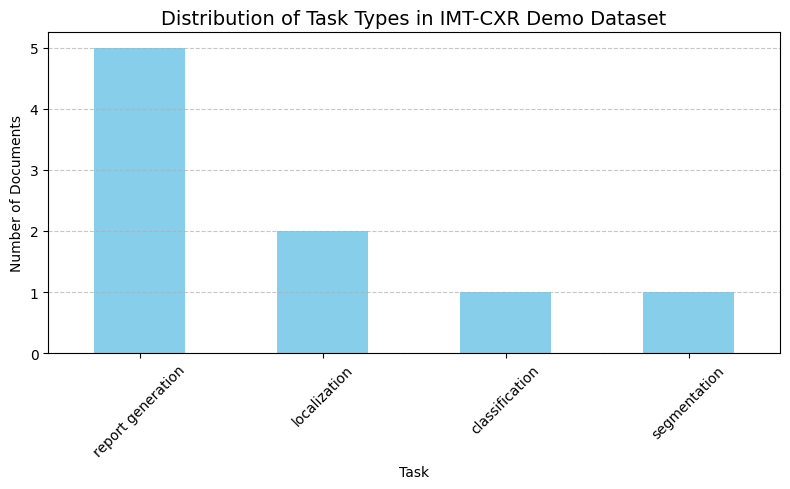

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("imt_cxr_demo_sample.csv")

# Count how many examples per Task
task_counts = df['Task'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
task_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Task Types in IMT-CXR Demo Dataset", fontsize=14)  #
plt.xlabel("Task")
plt.ylabel("Number of Documents")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# 7. Extracted image IDs

from datasets import load_dataset

# Load PadChest-like classification split
dataset = load_dataset("MedHK23/IMT-CXR", split="classification", streaming=True)

# Take a few examples
for i, doc in enumerate(dataset.take(100)):
    print(doc)


{'0': 1, '0.1': 1, '0.2': 1, 'atelectasis, right&base': 'effusion, right&base'}
{'0': 2, '0.1': 2, '0.2': 2, 'atelectasis, right&base': 'fracture, left&base'}
{'0': 3, '0.1': 3, '0.2': 3, 'atelectasis, right&base': 'effusion, right&mid'}
{'0': 4, '0.1': 4, '0.2': 4, 'atelectasis, right&base': 'pneumonia, left'}
{'0': 5, '0.1': 5, '0.2': 5, 'atelectasis, right&base': 'pneumonia, right'}
{'0': 6, '0.1': 6, '0.2': 6, 'atelectasis, right&base': 'consolidation, right'}
{'0': 7, '0.1': 7, '0.2': 7, 'atelectasis, right&base': 'atelectasis, left'}
{'0': 8, '0.1': 8, '0.2': 8, 'atelectasis, right&base': 'effusion, left'}
{'0': 9, '0.1': 9, '0.2': 9, 'atelectasis, right&base': 'atelectasis, right&base'}
{'0': 1, '0.1': 1, '0.2': 1, 'atelectasis,small&&effusion,small': 'fracture,mild'}
{'0': 2, '0.1': 2, '0.2': 2, 'atelectasis,small&&effusion,small': 'cardiomegaly,normal'}
{'0': 3, '0.1': 3, '0.2': 3, 'atelectasis,small&&effusion,small': 'effusion,small'}
{'0': 4, '0.1': 4, '0.2': 4, 'atelectasis

In [ ]:
from datasets import load_dataset

# Load the classification split (streaming mode)
dataset = load_dataset("MedHK23/IMT-CXR", split="classification", streaming=True)


# List to store image IDs
image_ids = []

# Take the first 200 examples
for i, doc in enumerate(dataset.take(200)):
    # Check keys once (optional, remove after confirming)
    if i < 5:
        print(f"Document {i} keys: {doc.keys()}")

    # Extract the image ID
    img_id = doc.get('ID')  # usually 'ID'

    # If 'ID' is missing, fallback to '0'
    if img_id is None:
        img_id = doc.get('0')

    image_ids.append(img_id)

# Show first 10 image IDs
print("\nFirst 10 image IDs:", image_ids[:200])


Document 0 keys: dict_keys(['0', '0.1', '0.2', 'atelectasis, right&base'])
Document 1 keys: dict_keys(['0', '0.1', '0.2', 'atelectasis, right&base'])
Document 2 keys: dict_keys(['0', '0.1', '0.2', 'atelectasis, right&base'])
Document 3 keys: dict_keys(['0', '0.1', '0.2', 'atelectasis, right&base'])
Document 4 keys: dict_keys(['0', '0.1', '0.2', 'atelectasis, right&base'])

First 10 image IDs: [1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
from datasets import load_dataset

dataset = load_dataset("MedHK23/IMT-CXR", split="classification", streaming=True)

image_ids = []
labels = []

for doc in dataset.take(5):
    # Look for the key that ends with '.png' — this contains the image ID
    img_key = [k for k in doc.keys() if k.endswith('.png')]
    if img_key:
        image_ids.append(doc[img_key[0]])   # The actual image ID
        labels.append(doc.get('Emphysema'))

print("First 5 image IDs:", image_ids[:5])
print("Corresponding labels:", labels[:5])


First 5 image IDs: []
Corresponding labels: []


In [ ]:
from datasets import load_dataset

# Load the dataset in streaming mode
dataset = load_dataset("MedHK23/IMT-CXR", split="classification", streaming=True)

total_docs = 0
docs_with_image = 0

for doc in dataset:
    total_docs += 1
    # Check if there is a key ending with '.png' (valid image)
    img_keys = [k for k in doc.keys() if k.endswith('.png')]
    if img_keys and doc[img_keys[0]]:
        docs_with_image += 1

print(f"Total documents: {total_docs}")
print(f"Documents with valid image ID: {docs_with_image}")
print(f"Documents with NULL image ID: {total_docs - docs_with_image}")


Total documents: 36
Documents with valid image ID: 9
Documents with NULL image ID: 27


In [ ]:
# 8. Generated synthetic image IDs

from datasets import load_dataset

# Load the dataset in streaming mode
dataset = load_dataset("MedHK23/IMT-CXR", split="classification", streaming=True)

image_ids = []

for doc in dataset:
    # Find the key that ends with '.png' (image ID)
    img_keys = [k for k in doc.keys() if k.endswith('.png')]
    if img_keys:
        img_id = doc[img_keys[0]]  # get the value
        if img_id:  # check it's not null
            image_ids.append(img_id)

print(f"Total extracted image IDs: {len(image_ids)}")
print("First 10 image IDs:", image_ids[:100])


Total extracted image IDs: 9
First 10 image IDs: ['10/8753062093280351072328738541736474049_zamnjm.png', '12/216840111366964013590140476722013057113628216_02-057-000.png', '10/289746164749769111711034221249204986488_is215o.png', '13/216840111366964013663026955732013120130333218_02-036-085.png', '37/216840111366964012558082906712009335134401265_00-087-101.png', '23/216840111366964014008416513202014196134745784_01-164-078.png', '26/216840111366964013451228379692012289130351879_01-119-180.png', '48/216840111366964012989926673512011146113306768_00-147-079.png', '45/216840111366964012373310883942009159095259241_00-093-001.png']


The above ID generated has this meaning : {folder}/{unique_hash}_{suffix}.png